# Playground for Performance Measure Slides

- Stephen W. Thomas
- Used for MMA 869, MMAI 869, and GMMA 869

In [1]:
import datetime
print(datetime.datetime.now())

2019-04-15 16:04:20.571969


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns 

from sklearn.metrics import silhouette_score, silhouette_samples
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

import itertools

import scipy

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Generate Data

For educational purposes, we'll generate a synthetic dataset, rather than using a real one, at first. We'll create a dataset that has two features, both informative, with some overlap, but not much.

Later, we'll graduate to using real-world datasets with more features and less seperation between classes.

In [3]:
from sklearn.datasets import make_classification
import random

# After experiementation, this random state generates a "good looking" dataset
r = 4184

X, y = make_classification(n_samples=500, n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=1, flip_y=0.09, class_sep = 1.1, random_state=r);

X1 = pd.DataFrame(X, columns=['Age', 'Income'])
y1 = pd.Series(y, name='Default')
df = pd.concat([X1, y1], axis=1)

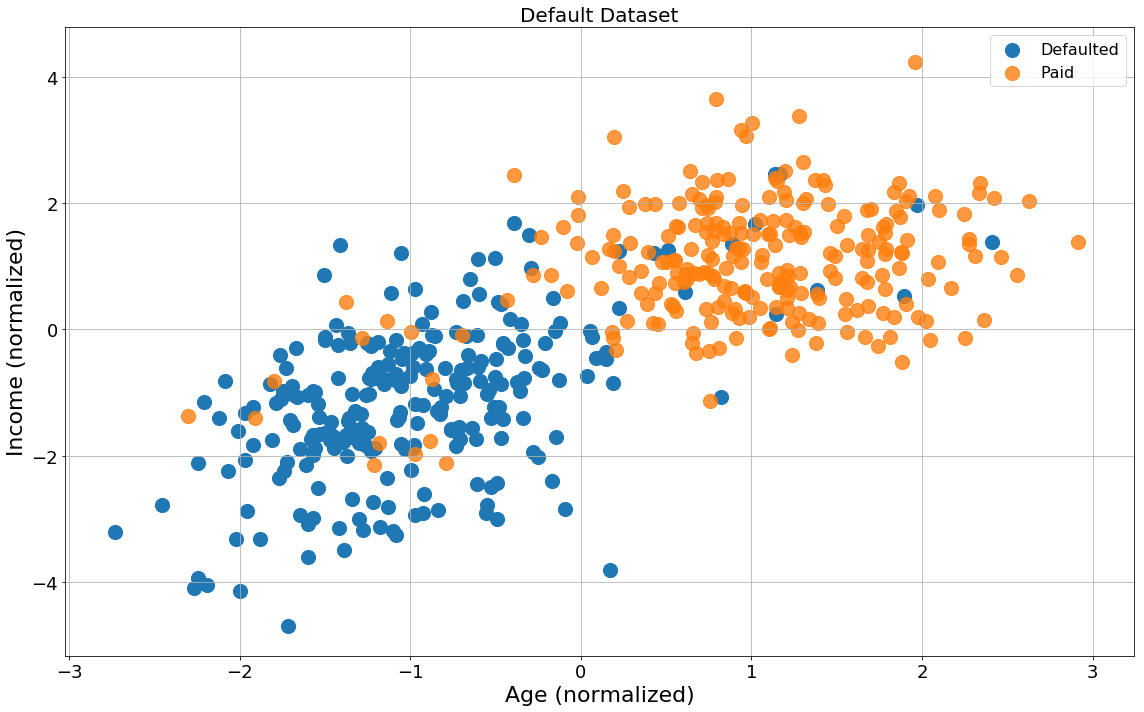

In [4]:
plt.figure(figsize=(16, 10));
plt.grid(True);

ind_d = y==1
ind_p = y==0
plt.scatter(X[ind_d,0], X[ind_d,1], marker='o', s=200, label='Defaulted');
plt.scatter(X[ind_p,0], X[ind_p,1], marker='o', s=200, label="Paid", alpha=0.8);

plt.legend(fontsize=16);
plt.title("Default Dataset", fontsize=20);
plt.xlabel('Age (normalized)', fontsize=22);
plt.ylabel('Income (normalized)', fontsize=22);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.tight_layout();
plt.savefig('out/default-data.png');

# Helper Functions for Plotting Decision Boundary, etc.

In [5]:
from matplotlib.colors import ListedColormap
from sklearn.metrics import roc_curve, auc

# Adopted from: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

def plot_boundaries(X_train, X_test, y_train, y_test, clf, clf_name, ax, hide_ticks=True):
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    X = np.concatenate((X_train, X_test), axis=0)
    y = np.concatenate((y_train, y_test), axis=0)
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02));
    
    
    score = clf.score(X_test, y_test);

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]);
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1];

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8);

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=100, cmap=cm_bright, edgecolors='k');
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap=cm_bright, edgecolors='k', alpha=0.6);

    ax.set_xlim(xx.min(), xx.max());
    ax.set_ylim(yy.min(), yy.max());
    if hide_ticks:
        ax.set_xticks(());
        ax.set_yticks(());
    else:
        ax.tick_params(axis='both', which='major', labelsize=18)
        #ax.yticks(fontsize=18);
        
    ax.set_title(clf_name, fontsize=28);
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'), size=35, horizontalalignment='right');
    ax.grid();
    
    


def plot_roc(clf, X_test, y_test, name, ax, show_thresholds=True):
    y_pred_rf = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thr = roc_curve(y_test, y_pred_rf)

    ax.plot([0, 1], [0, 1], 'k--');
    ax.plot(fpr, tpr, label='{}, AUC={:.2f}'.format(name, auc(fpr, tpr)));
    ax.scatter(fpr, tpr);

    if show_thresholds:
        for i, th in enumerate(thr):
            ax.text(x=fpr[i], y=tpr[i], s="{:.2f}".format(th), fontsize=14, 
                     horizontalalignment='left', verticalalignment='top', color='black',
                     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1', alpha=0.1));
        
    ax.set_xlabel('False positive rate', fontsize=18);
    ax.set_ylabel('True positive rate', fontsize=18);
    ax.tick_params(axis='both', which='major', labelsize=18);
    ax.grid(True);
    ax.set_title('ROC Curve', fontsize=18)

# Decision Trees

### Use All The Data

In [6]:
from sklearn.tree import DecisionTreeClassifier

clf_all = DecisionTreeClassifier(random_state=42, criterion="entropy",
                             min_samples_split=2, min_samples_leaf=1, max_depth=100, max_leaf_nodes=500)
clf_all.fit(X, y)

y_pred_dt = clf_all.predict(X)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=100,
            max_features=None, max_leaf_nodes=500,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [7]:
feature_names = X1.columns
class_names = [str(x) for x in clf_all.classes_]

## Model Performance

In [8]:
from pandas_ml import ConfusionMatrix

print(ConfusionMatrix(y, y_pred_dt))

Predicted  False  True  __all__
Actual                         
False        251     0      251
True           0   249      249
__all__      251   249      500


In [9]:
from sklearn.metrics import classification_report

print(classification_report(y, y_pred_dt, target_names=class_names))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       251
          1       1.00      1.00      1.00       249

avg / total       1.00      1.00      1.00       500



In [10]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, log_loss

print("Accuracy = {:.2f}".format(accuracy_score(y, y_pred_dt)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y, y_pred_dt)))
print("F1 Score = {:.2f}".format(f1_score(y, y_pred_dt)))
print("Log Loss = {:.2f}".format(log_loss(y, y_pred_dt)))

Accuracy = 1.00
Kappa = 1.00
F1 Score = 1.00
Log Loss = 0.00


### ROC Curve

#### With YellowBrick

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000022CBC8F6400>,
    classes=None, macro=True, micro=True, model=None, per_class=True)

1.0

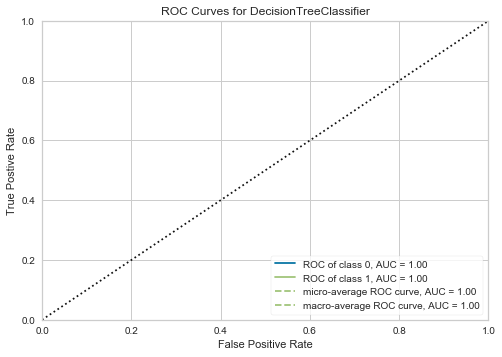

In [11]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(clf_all, classes=class_names)

visualizer.fit(X, y)  # Fit the training data to the visualizer
visualizer.score(X, y)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

#### Manual

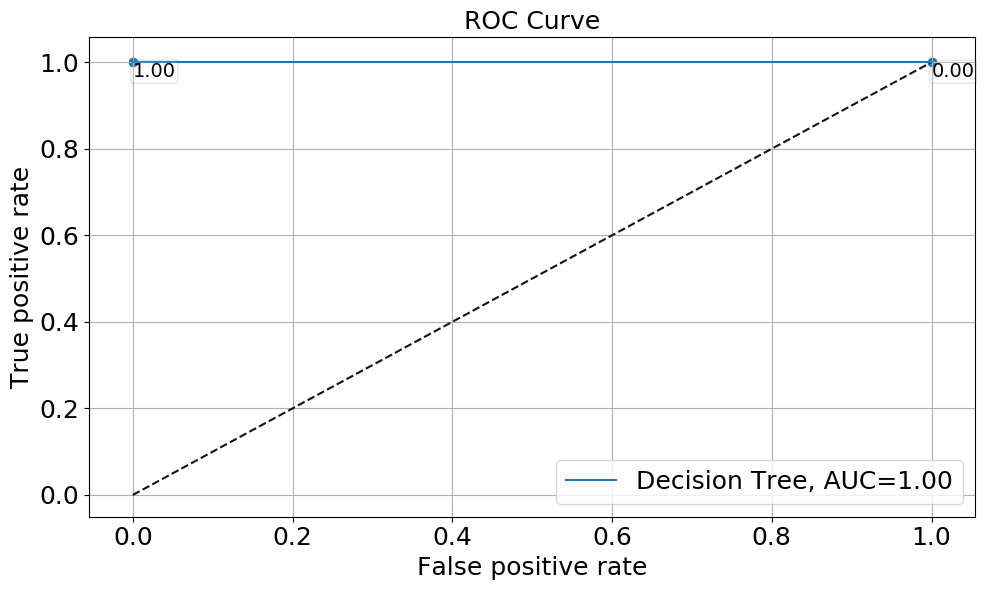

In [12]:
plt.style.use('default');
figure = plt.figure(figsize=(10, 6));    
ax = plt.subplot(1, 1, 1);
plot_roc(clf_all, X, y, "Decision Tree", ax)
plt.legend(loc='lower right', fontsize=18);
plt.tight_layout();
plt.savefig('out/default-dt-roc.png');

### Discrimintation Threshold

DiscriminationThreshold(argmax='fscore',
            ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000022CBC96F278>,
            cv=0.1, exclude=None, fbeta=1.0, model=None, n_trials=50,
            quantiles=array([0.1, 0.5, 0.9]), random_state=None)

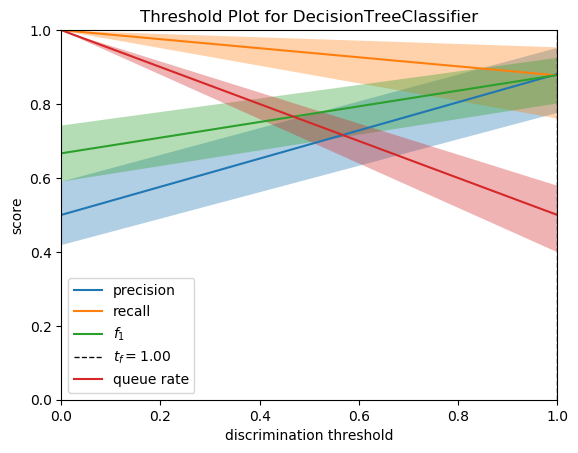

In [13]:
from yellowbrick.classifier import DiscriminationThreshold

visualizer = DiscriminationThreshold(clf_all)
visualizer.fit(X, y)  # Fit the training data to the visualizer
visualizer.poof()     # Draw/show/poof the data

### Decision Boundary

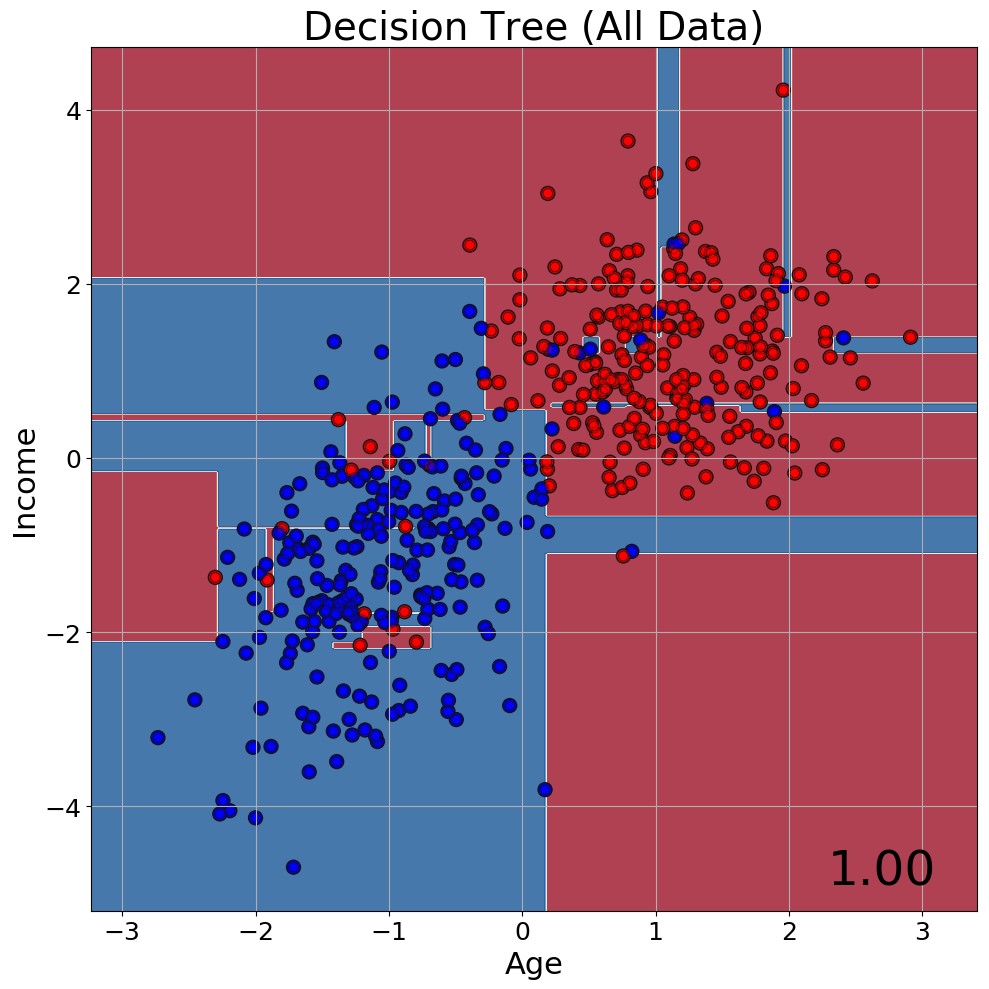

In [14]:
figure = plt.figure(figsize=(10, 10));
ax = plt.subplot(1, 1, 1);
plot_boundaries(X, X, y, y, clf_all, "Decision Tree (All Data)", ax, hide_ticks=False)
ax.set_xlabel("Age", fontsize=22)
ax.set_ylabel("Income", fontsize=22)
plt.tight_layout();
plt.savefig('out/default-dt-alldata-boundaries.png');

# Holdout

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48)
clf_holdout = DecisionTreeClassifier(random_state=42, criterion="entropy",
                             min_samples_split=2, min_samples_leaf=1, max_depth=100, max_leaf_nodes=500)
clf_holdout.fit(X_train, y_train)
y_pred_holdout = clf_holdout.predict(X_test)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=100,
            max_features=None, max_leaf_nodes=500,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [16]:
print(ConfusionMatrix(y_test, y_pred_holdout))

Predicted  False  True  __all__
Actual                         
False         45     6       51
True           5    44       49
__all__       50    50      100


In [17]:
print(classification_report(y_test, y_pred_holdout, target_names=class_names))

             precision    recall  f1-score   support

          0       0.90      0.88      0.89        51
          1       0.88      0.90      0.89        49

avg / total       0.89      0.89      0.89       100



In [18]:
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_holdout)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_holdout)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_holdout)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_holdout)))

Accuracy = 0.89
Kappa = 0.78
F1 Score = 0.89
Log Loss = 3.80


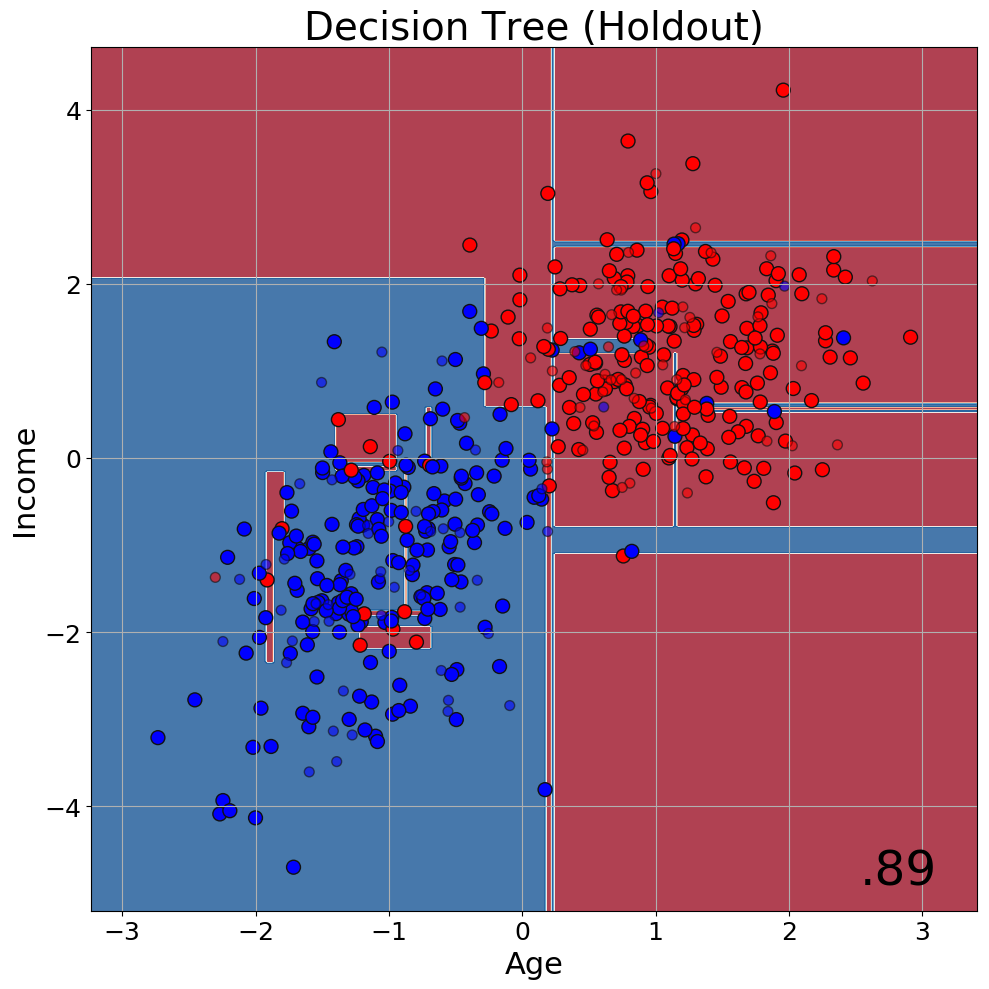

In [19]:
figure = plt.figure(figsize=(10, 10));
ax = plt.subplot(1, 1, 1);
plot_boundaries(X_train, X_test, y_train, y_test, clf_holdout, "Decision Tree (Holdout)", ax, hide_ticks=False)
ax.set_xlabel("Age", fontsize=22)
ax.set_ylabel("Income", fontsize=22)
plt.tight_layout();
plt.savefig('out/default-dt-holdout-boundaries.png');

## CV

In [20]:
from sklearn.model_selection import cross_val_score
clf_cv = DecisionTreeClassifier(random_state=42, criterion="entropy",
                             min_samples_split=2, min_samples_leaf=1, max_depth=100, max_leaf_nodes=500)

scores = cross_val_score(clf_cv, X, y, cv=10, scoring="accuracy")

In [21]:
scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

array([0.88235294, 0.82      , 0.86      , 0.8       , 0.88      ,
       0.92      , 0.82      , 0.88      , 0.82      , 0.89795918])

Accuracy: 0.86 (+/- 0.08)


# Bias/Variance

ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000022CBD841A90>,
        cv=5, groups=None, logx=False, model=None, n_jobs=1,
        param_name='max_depth', param_range=array([1, 2, 3, 4, 5, 6]),
        pre_dispatch='all', scoring='roc_auc')

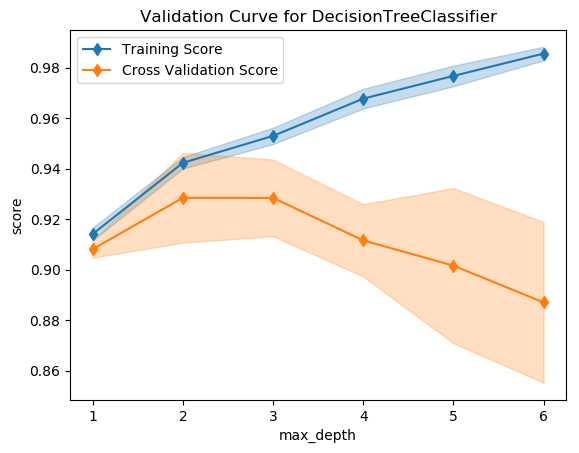

In [22]:
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(DecisionTreeClassifier(), param_name="max_depth", param_range=np.arange(1, 7), cv=5, scoring="roc_auc")
viz.fit(X, y)
viz.poof(outpath='out/default-dt_validation_curve-bias.png')
viz.poof()